In [1]:
from pathlib import Path
import re, numpy as np, pandas as pd, mne
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("ERROR")

In [2]:
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  

In [3]:
DATA = Path(f"{parentPath}/data")
DER  = DATA / "derivatives"  
FIGS = Path(f"{parentPath}/figs"); FIGS.mkdir(parents=True, exist_ok=True)

In [4]:
# bands for FB-CSP
FB = {"mu1":(8,12), "mu2":(12,16), "beta1":(16,22), "beta2":(22,30)}

In [20]:
# paths = sorted(DER.glob("*-aligned128-epo.fif")) # all at 128 Hz, same tmin/tmax #or sorted(DER.glob("*-epo.fif"))
paths = sorted(DER.glob("*-aligned128-epo.fif")) or sorted(DER.glob("*-epo.fif"))

# paths = [p for p in paths if re.search(r"R(03|04|07|08|11|12)", p.name)] # only these subjects have both L and R hand MI
# paths = [p for p in paths if re.search(r"R(04|08|12)", p.name)]  # L/R imagery only
paths = [p for p in paths if re.search(r"R(03|07|11)", p.name)]  # L/R exec only
# paths = [p for p in paths if re.search(r"R(06|10|14)", p.name)]  # both imagery only

print("Files:", len(paths))


Files: 327


In [23]:
target_sfreq = 128
tmin, tmax = -0.2, 0.8

X_list, y_list, runs, chs = [], [], [], None
for p in paths:
    ep = mne.read_epochs(p, preload=True, verbose=False)
    if len(ep) == 0: continue

    # ensure consistent channels/order
    if chs is None:
        chs = ep.ch_names
    ep.pick(chs)

    # align time base
    if ep.info["sfreq"] != target_sfreq:
        ep.resample(target_sfreq, npad="auto")
    if (ep.tmin, ep.tmax) != (tmin, tmax):
        ep.crop(tmin, tmax)

    X_list.append(ep.get_data())                  # (n_ep, n_ch, n_t)
    y_list.append(ep.events[:, -1])
    run = int(re.search(r"R(\d{2})", p.name).group(1))
    runs.extend([run]*len(ep))

X = np.concatenate(X_list, axis=0)               # now shapes match
y = np.concatenate(y_list); runs = np.array(runs)
print("Raw epochs cube:", X.shape, "labels:", np.unique(y), "runs:", np.unique(runs))


Raw epochs cube: (1276, 64, 129) labels: [1 2] runs: [ 3  7 11]


In [ ]:
# X_list, y_list, runs, chs = [], [], [], None
# for p in paths:
#     ep = mne.read_epochs(p, preload=True, verbose=False)
#     if len(ep)==0: continue
#     if chs is None: chs = ep.ch_names
#     X_list.append(ep.get_data())       # (n_ep, n_ch, n_t)
#     y_list.append(ep.events[:, -1])    # (n_ep,)
#     run = int(re.search(r"R(\d{2})", p.name).group(1)); runs.extend([run]*len(ep))
# X = np.concatenate(X_list, axis=0); y = np.concatenate(y_list); runs = np.array(runs)
# print("Raw epochs cube:", X.shape, "labels:", np.unique(y), "runs:", np.unique(runs))


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 161 and the array at index 115 has size 129

In [24]:
# for p in paths:
#     ep = mne.read_epochs(p, preload=False, verbose=False)
#     print(f"{p.name:28s} sfreq={ep.info['sfreq']:>6.1f}  tmin={ep.tmin:>5.2f}  tmax={ep.tmax:>5.2f}  shape={ep.get_data().shape}")


In [25]:
from mne.decoding import CSP

def eval_csp_singleband(X, y, runs, fmin=8, fmax=30, n_csp=6, clf="lda", n_splits=3):
    gkf = GroupKFold(n_splits=min(n_splits, np.unique(runs).size))
    metrics = []
    cms = []
    for fold, (tr, te) in enumerate(gkf.split(X, y, runs)):
        # bandpass (fit on raw arrays via MNE filter on-the-fly)
        Xtr = mne.filter.filter_data(X[tr].transpose(0,2,1), sfreq=128, l_freq=fmin, h_freq=fmax, verbose=False).transpose(0,2,1)
        Xte = mne.filter.filter_data(X[te].transpose(0,2,1), sfreq=128, l_freq=fmin, h_freq=fmax, verbose=False).transpose(0,2,1)

        csp = CSP(n_components=n_csp, reg='ledoit_wolf', log=True, norm_trace=False)
        csp.fit(Xtr, y[tr])
        Ztr, Zte = csp.transform(Xtr), csp.transform(Xte)

        if clf=="lda":
            cls = LDA()
        else:
            cls = LogisticRegression(max_iter=2000, class_weight="balanced")
        cls.fit(Ztr, y[tr]); yhat = cls.predict(Zte)

        metrics.append(dict(
            fold=fold,
            acc=accuracy_score(y[te], yhat),
            kappa=cohen_kappa_score(y[te], yhat),
            f1_macro=f1_score(y[te], yhat, average="macro")
        ))
        cms.append(confusion_matrix(y[te], yhat))
    return pd.DataFrame(metrics), cms, csp


In [26]:
df_csp, cms_csp, csp_model = eval_csp_singleband(X, y, runs, n_csp=6, clf="lda", n_splits=3)
print("CSP 8–30Hz (mean):\n", df_csp.mean(numeric_only=True).round(3))


CSP 8–30Hz (mean):
 fold        1.000
acc         0.553
kappa       0.106
f1_macro    0.552
dtype: float64


In [27]:
def eval_fb_csp(X, y, runs, fb=FB, n_csp=2, clf="lda", n_splits=3, sfreq=128):
    gkf = GroupKFold(n_splits=min(n_splits, np.unique(runs).size))
    metrics, cms = [], []

    for fold, (tr, te) in enumerate(gkf.split(X, y, runs)):
        Ztr_bands, Zte_bands, csps = [], [], {}
        for bname, (lo, hi) in fb.items():
            Xtr = mne.filter.filter_data(X[tr].transpose(0,2,1), sfreq=sfreq, l_freq=lo, h_freq=hi, verbose=False).transpose(0,2,1)
            Xte = mne.filter.filter_data(X[te].transpose(0,2,1), sfreq=sfreq, l_freq=lo, h_freq=hi, verbose=False).transpose(0,2,1)

            csp = CSP(n_components=n_csp, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xtr, y[tr])
            Ztr_bands.append(csp.transform(Xtr))   # (n_tr, 2*n_csp? actually n_csp)
            Zte_bands.append(csp.transform(Xte))
            csps[bname] = csp

        Ztr = np.concatenate(Ztr_bands, axis=1)
        Zte = np.concatenate(Zte_bands, axis=1)

        model = LDA() if clf=="lda" else LogisticRegression(max_iter=2000, class_weight="balanced")
        model.fit(Ztr, y[tr]); yhat = model.predict(Zte)

        metrics.append(dict(
            fold=fold,
            acc=accuracy_score(y[te], yhat),
            kappa=cohen_kappa_score(y[te], yhat),
            f1_macro=f1_score(y[te], yhat, average="macro")
        ))
        cms.append(confusion_matrix(y[te], yhat))
    return pd.DataFrame(metrics), cms


In [28]:
df_fbcsp, cms_fb = eval_fb_csp(X, y, runs, fb=FB, n_csp=2, clf="lda", n_splits=3)
print("FB-CSP (mean):\n", df_fbcsp.mean(numeric_only=True).round(3))


FB-CSP (mean):
 fold        1.000
acc         0.603
kappa       0.207
f1_macro    0.602
dtype: float64


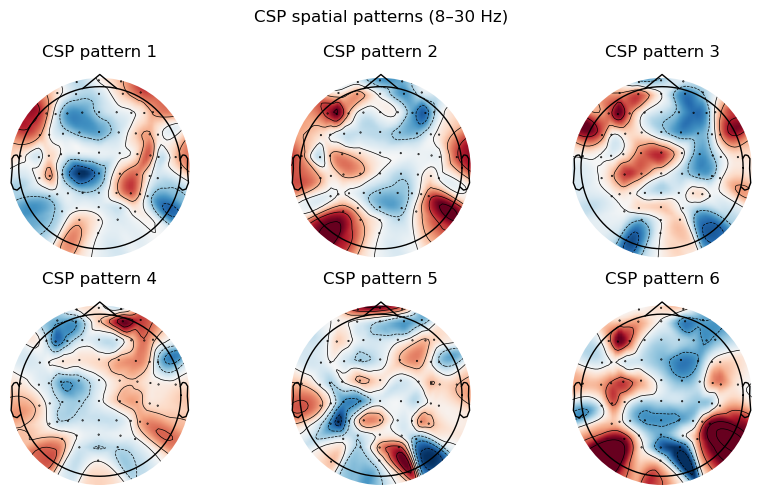

In [30]:
# 1) clean channel names (EEGBCI often has trailing dots like 'Fc5.')
chs_fixed = [c.rstrip('.') for c in chs]

# 2) build info with a standard montage
mont = mne.channels.make_standard_montage('standard_1020')  # or 'biosemi64' if that's your cap
info = mne.create_info(chs_fixed, sfreq=128., ch_types='eeg')
info.set_montage(mont, match_case=False, on_missing='ignore')  # attach positions

# 3) plot CSP spatial patterns
fig, axes = plt.subplots(2, 3, figsize=(9, 5))
for i, ax in enumerate(axes.ravel()):
    mne.viz.plot_topomap(csp_full.patterns_[i], info, axes=ax, show=False)
    ax.set_title(f"CSP pattern {i+1}")
fig.suptitle("CSP spatial patterns (8–30 Hz)")
fig.tight_layout()
fig.savefig(FIGS / "csp_patterns.png", dpi=150)


RuntimeError: No digitization points found.

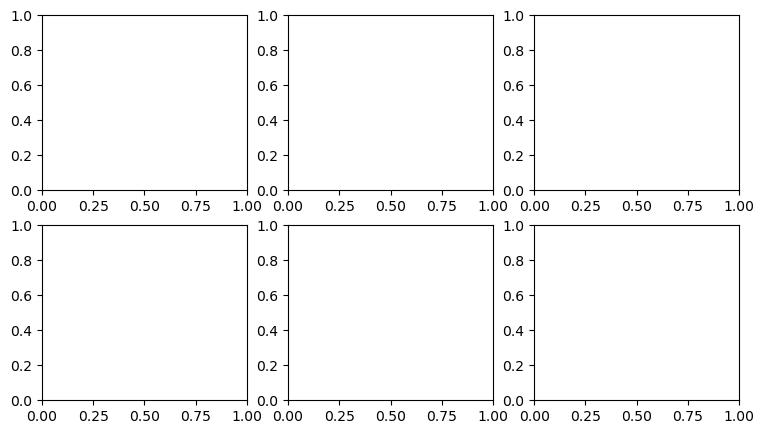

In [29]:
# Fit once on all data to visualize (for the 8–30 Hz CSP)
csp_full = CSP(n_components=6, reg='ledoit_wolf', log=True).fit(
    mne.filter.filter_data(X.transpose(0,2,1), sfreq=128, l_freq=8, h_freq=30, verbose=False).transpose(0,2,1),
    y
)
info = mne.create_info(chs, sfreq=128., ch_types="eeg")
evoked = mne.EvokedArray(np.eye(len(chs)), info)  # dummy for topomap
fig, axes = plt.subplots(2,3, figsize=(9,5))
for i, ax in enumerate(axes.ravel()):
    mne.viz.plot_topomap(csp_full.patterns_[i], evoked.info, axes=ax, show=False)
    ax.set_title(f"CSP pattern {i+1}")
fig.suptitle("CSP spatial patterns (8–30 Hz)"); fig.tight_layout(); fig.savefig(FIGS/"csp_patterns.png", dpi=150)
